In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV, learning_curve, validation_curve
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from itertools import cycle, islice, product
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import homogeneity_completeness_v_measure, silhouette_score
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering, Birch

import warnings
warnings.filterwarnings('ignore')

In [2]:
dataset = pd.read_csv('./Datasets/air_satisfaction.csv')
dataset.head()

,Num,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


In [3]:
dataset.drop(['Num','id'], axis=1, inplace=True)
dataset.dropna(subset='Arrival Delay in Minutes', axis=0, inplace=True)
le = LabelEncoder()
dataset['satisfaction']= le.fit_transform(dataset['satisfaction'])
dataset['Gender']= le.fit_transform(dataset['Gender'])
dataset['Customer Type']= le.fit_transform(dataset['Customer Type'])
dataset['Type of Travel']= le.fit_transform(dataset['Type of Travel'])
dataset['Class']= le.fit_transform(dataset['Class'])

In [4]:
dataset = dataset.iloc[:1000 , :]
dataset.shape

(1000, 23)

In [5]:
dataset.dtypes

Gender                                 int64
Customer Type                          int64
Age                                    int64
Type of Travel                         int64
Class                                  int64
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure Delay in Minutes             int64
Arrival Delay in Minutes             float64
satisfacti

In [6]:
dataset_copy = dataset.copy()
D1 = pd.DataFrame(data=dataset, columns=['Customer Type', 'Type of Travel', 'Class', 
                                         'Inflight wifi service', 'Flight Distance'])
D1

,Customer Type,Type of Travel,Class,Inflight wifi service,Flight Distance
0,0,0,1,5,160
1,0,0,0,1,2863
2,1,0,1,2,192
3,0,0,0,0,3377
4,0,0,1,2,1182
...,...,...,...,...,...
997,0,0,0,2,482
998,0,1,2,3,1504
999,1,0,1,1,601
1000,0,1,1,2,1990


In [7]:
pca = PCA(n_components=2)
D2 = pca.fit_transform(D1)
print('Доля объясненной дисперсии: {}, сумма = {}'.format(pca.explained_variance_ratio_, 
                                                          np.sum(pca.explained_variance_ratio_)))

Доля объясненной дисперсии: [9.99997599e-01 1.77867169e-06], сумма = 0.9999993774283477


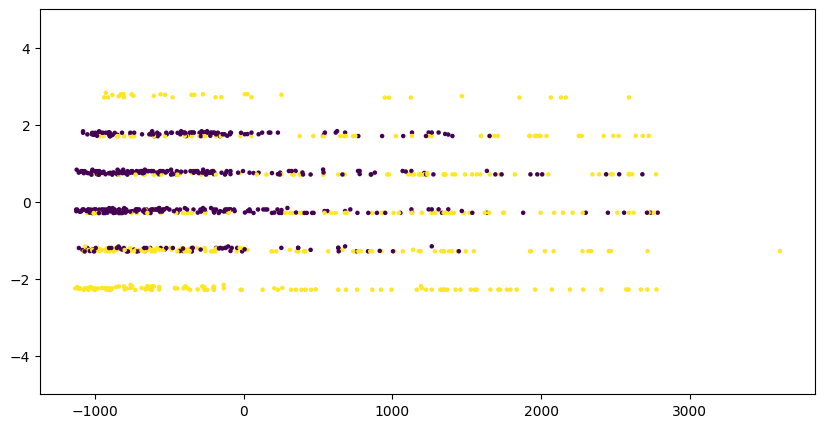

In [8]:
y = dataset['satisfaction']
plt.figure(figsize=(10,5))
plt.scatter(D2[:, 0], D2[:, 1], s=5, c=y)
# plt.axis('equal')
plt.ylim([-5, 5])
plt.show()

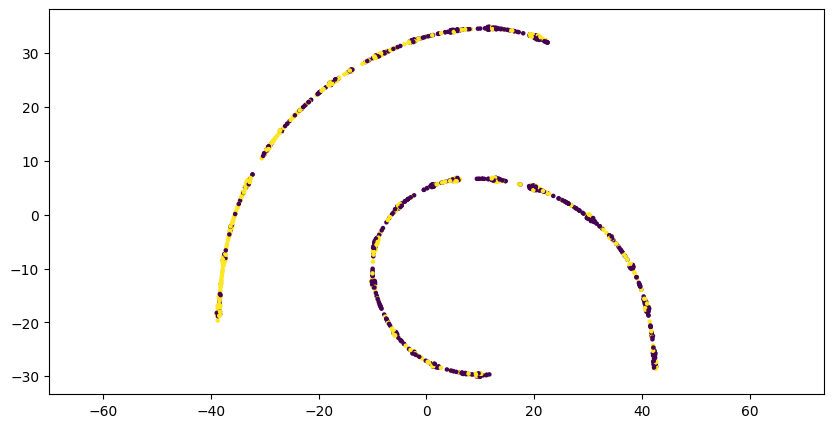

In [9]:
tsne = TSNE(n_components=2, random_state=16)
D3 = tsne.fit_transform(D1)
plt.figure(figsize=(10,5))
plt.scatter(D3[:, 0], D3[:, 1], s=5, c=y)
plt.axis('equal')
plt.show()

In [10]:
def do_clustering(cluster_datasets, method):
    """
    Выполнение кластеризации для данных примера
    """
    cluster_results = []
    for X in cluster_datasets:
        temp_cluster = method.fit_predict(X)
        cluster_results.append(temp_cluster)
    return cluster_results

In [11]:
def visualize_clusters(cluster_datasets, cluster_results):
    """
    Визуализация результатов кластерного анализа
    """
    plt.subplots(figsize=(16,8))
    plot_num = 0
    for X, y_pred in zip(cluster_datasets, cluster_results):
        plot_num += 1
        plt.subplot(2, 3, plot_num)
        # Цвета точек как результат кластеризации
        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # черный цвет для выделяющихся значений
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=3, color=colors[y_pred])
#         plt.xlim(-2.5, 2.5)
#         plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.title(datasets_names[plot_num-1])
    
    plt.show()

In [12]:
cluster_datasets = [D2, D3]
cluster_datasetD1 = [D1]
datasets_names = ['D2', 'D3']

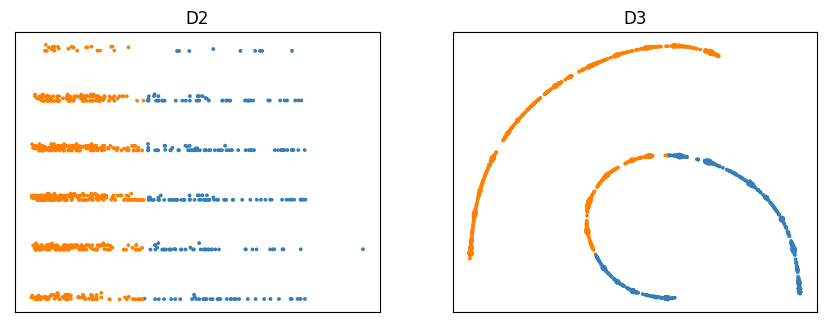

In [13]:
result_KMeans1 = do_clustering(cluster_datasetD1, KMeans(n_clusters=2))
result_KMeans23 = do_clustering(cluster_datasets, KMeans(n_clusters=2))
visualize_clusters(cluster_datasets, result_KMeans23)

In [14]:
print('Adjusted rand score:')
print('D1: ', adjusted_rand_score(y, result_KMeans1[0]))
print('D2: ', adjusted_rand_score(y, result_KMeans23[0]))
print('D3: ', adjusted_rand_score(y, result_KMeans23[1]))

Adjusted rand score:
D1:  0.09262111757540727
D2:  0.09262111757540727
D3:  0.020611220928941937


In [15]:
# Homogeneity - каждый кластер содержит только представителей единственного класса (под классом понимается истинное значение метки кластера). Значение в диапазоне [0;1], 1 говорит об очень хорошем качестве кластеризации.
# Completeness - все элементы одного класса помещены в один и тот же кластер. Значение в диапазоне [0;1], 1 говорит об очень хорошем качестве кластеризации.
# V-measure - среднее гармоническое от Homogeneity и Completeness.
h1, c1, v1 = homogeneity_completeness_v_measure(y, result_KMeans1[0])
h2, c2, v2 = homogeneity_completeness_v_measure(y, result_KMeans23[0])
h3, c3, v3 = homogeneity_completeness_v_measure(y, result_KMeans23[1])
print('Homogenity:')
print('D1: ', h1)
print('D2: ', h2)
print('D3: ', h3)
print('Completeness:')
print('D1: ', c1)
print('D2: ', c2)
print('D3: ', c3)
print('V-measure:')
print('D1: ', v1)
print('D2: ', v2)
print('D3: ', v3)

Homogenity:
D1:  0.06761342414342844
D2:  0.06761342414342844
D3:  0.021755083464586274
Completeness:
D1:  0.08045705691619928
D2:  0.08045705691619928
D3:  0.022422688482558996
V-measure:
D1:  0.07347821220917457
D2:  0.07347821220917457
D3:  0.022083841621623926


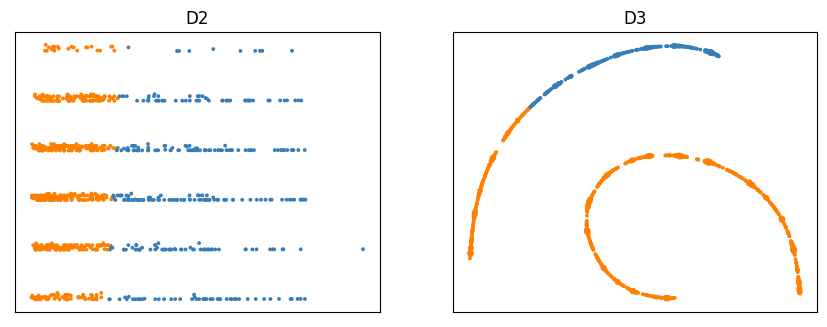

In [16]:
result_GaussianMixture1 = do_clustering(cluster_datasetD1, GaussianMixture(n_components=2))
result_GaussianMixture23 = do_clustering(cluster_datasets, GaussianMixture(n_components=2))
visualize_clusters(cluster_datasets, result_GaussianMixture23)

In [17]:
print('Adjusted rand score:')
print('D1: ', adjusted_rand_score(y, result_GaussianMixture1[0]))
print('D2: ', adjusted_rand_score(y, result_GaussianMixture23[0]))
print('D3: ', adjusted_rand_score(y, result_GaussianMixture23[1]))

Adjusted rand score:
D1:  0.01930050152730678
D2:  0.08733557338901465
D3:  -0.0027063956033279014


In [18]:
h1, c1, v1 = homogeneity_completeness_v_measure(y, result_GaussianMixture1[0])
h2, c2, v2 = homogeneity_completeness_v_measure(y, result_GaussianMixture23[0])
h3, c3, v3 = homogeneity_completeness_v_measure(y, result_GaussianMixture23[1])
print('Homogenity:')
print('D1: ', h1)
print('D2: ', h2)
print('D3: ', h3)
print('Completeness:')
print('D1: ', c1)
print('D2: ', c2)
print('D3: ', c3)
print('V-measure:')
print('D1: ', v1)
print('D2: ', v2)
print('D3: ', v3)

Homogenity:
D1:  0.022257650416520884
D2:  0.059786560234593666
D3:  0.001365728916708042
Completeness:
D1:  0.02331956038656028
D2:  0.06370976205188172
D3:  0.0016941624470538225
V-measure:
D1:  0.022776234605208383
D2:  0.06168584547174965
D3:  0.0015123194705172094


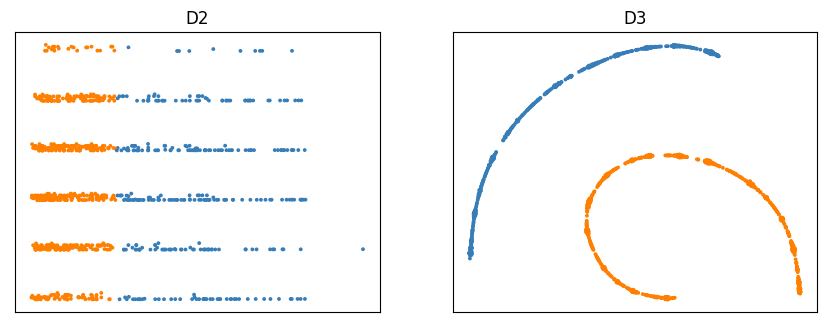

In [19]:
result_Birch1 = do_clustering(cluster_datasetD1, Birch(n_clusters=2))
result_Birch23 = do_clustering(cluster_datasets, Birch(n_clusters=2))
visualize_clusters(cluster_datasets, result_Birch23)

In [20]:
print('Adjusted rand score:')
print('D1: ', adjusted_rand_score(y, result_Birch1[0]))
print('D2: ', adjusted_rand_score(y, result_Birch23[0]))
print('D3: ', adjusted_rand_score(y, result_Birch23[1]))

Adjusted rand score:
D1:  0.09086873489922227
D2:  0.09086873489922227
D3:  0.045621370199032736


In [21]:
h1, c1, v1 = homogeneity_completeness_v_measure(y, result_Birch1[0])
h2, c2, v2 = homogeneity_completeness_v_measure(y, result_Birch23[0])
h3, c3, v3 = homogeneity_completeness_v_measure(y, result_Birch23[1])
print('Homogenity:')
print('D1: ', h1)
print('D2: ', h2)
print('D3: ', h3)
print('Completeness:')
print('D1: ', c1)
print('D2: ', c2)
print('D3: ', c3)
print('V-measure:')
print('D1: ', v1)
print('D2: ', v2)
print('D3: ', v3)

Homogenity:
D1:  0.06258552390534933
D2:  0.06258552390534933
D3:  0.03153952570958802
Completeness:
D1:  0.06743526135349996
D2:  0.06743526135349996
D3:  0.03167122256090866
V-measure:
D1:  0.0649199457317645
D2:  0.0649199457317645
D3:  0.031605236942910626
